In [293]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import color
from skimage import io
import numba
from numba import jit

In [294]:
edge = np.linspace(0, 1, 100)
xv, yv = np.meshgrid(edge, edge)

In [295]:
img = color.rgb2gray(io.imread('../../Desktop/d.png'))
img = np.flip(img, axis=0)

/var/folders/gy/tmq5jzf548s8qn2v9c_qy52c0000gn/T/ipykernel_60232/3966780338.py:1: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = color.rgb2gray(io.imread('../../Desktop/d.png'))


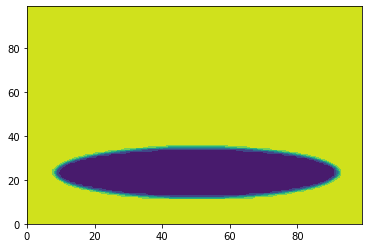

In [296]:
plt.contourf(img)

In [297]:
materialey_bool = img<0.9

In [298]:
materialey_bool

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [299]:
a_material = 1.4e-7  #Quartz

In [300]:
rawmaterial_temp = 273 + 30
oven_temp = 273 + 200

In [301]:
init_heat = np.zeros([100,100]) + oven_temp
init_heat[materialey_bool] = rawmaterial_temp

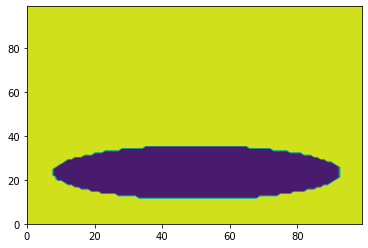

In [302]:
plt.contourf(init_heat)

In [303]:
times = 36000
times_snapshot = 3600
f = int(times/times_snapshot)
heat_frames = np.zeros([times_snapshot, 100, 100])
heat_frames[0] = init_heat

In [304]:
f

10

In [305]:
x = 0.5
dx = 0.5/100
dt = 1

In [306]:
a_material * dt / dx**2

0.0056

In [307]:
@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, is_materialey):
    cs = heatmap[0].copy() #current state
    length = len(cs[0])
    cf = 0 # current frame
    for t in range(1,times):
        ns = cs.copy() # new state
        for i in range(1, length-1):
            for j in range(1, length-1):
                if is_materialey[j][i]:
                    a = a_material
                    ns[j][i] = cs[j][i] + a*dt/dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                    cs[j][i+1] + cs[j][i-1] -\
                                                    4*cs[j][i])
        cs = ns.copy()
        if t%f==0:
            cf = cf + 1
            heatmap[cf] = cs
            
    return heatmap

In [308]:
heat_frames = solve_heat(heat_frames, materialey_bool)

In [309]:
heat_frames -= 273.15

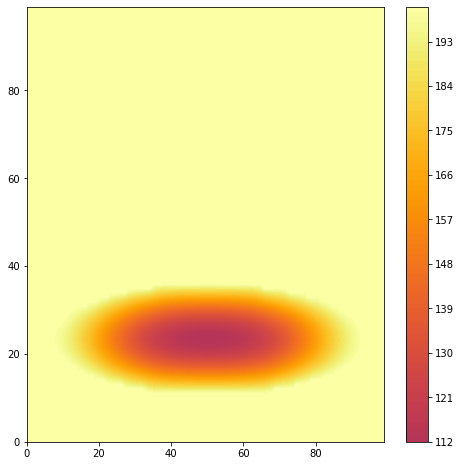

In [310]:
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
a = plt.contourf(heat_frames[1000], 100, cmap=my_cmap, vmin=rawmaterial_temp-273, vmax=oven_temp-273)
plt.colorbar(a)

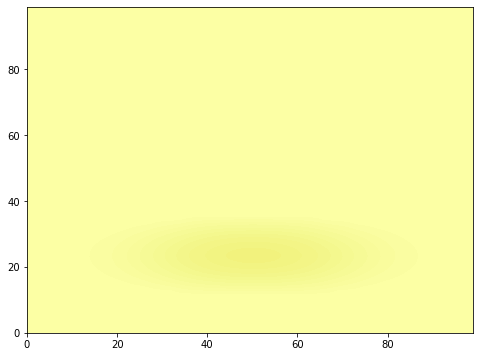

In [315]:
def animate(i):
    ax.clear()
    ax.contourf(heat_frames[10*i], 100, cmap=my_cmap, vmin=rawmaterial_temp-273, vmax = oven_temp-273)

    return fig,

fig, ax = plt.subplots(figsize=(8,6))
ani = animation.FuncAnimation(fig, animate,
                               frames=359, interval=50)
ani.save('heated_quartz.gif',writer='pillow',fps=30)

In [316]:
t = np.linspace(0, 10, len(heat_frames))

In [317]:
avg_temp = np.array([heat_frame[materialey_bool].mean() for heat_frame in heat_frames]) 
min_temp = np.array([heat_frame[materialey_bool].min() for heat_frame in heat_frames]) 
std_temp = np.array([heat_frame[materialey_bool].std() for heat_frame in heat_frames]) 

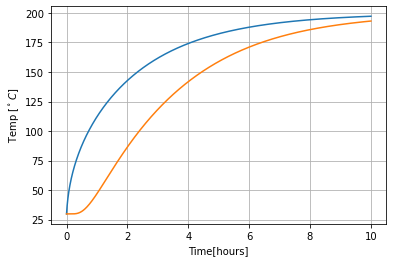

In [314]:
plt.plot(t, avg_temp, label='average')
plt.plot(t, min_temp, label='average')
plt.xlabel('Time[hours]')
plt.ylabel('Temp [$^\circ C$]')
plt.grid()